Samprada Shrestha
Workshop 5


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = "/content/drive/MyDrive/AIML/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AIML/FruitinAmazon/test"

In [5]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['graviola', 'pupunha', 'cupuacu', 'guarana', 'acai', 'tucuma']


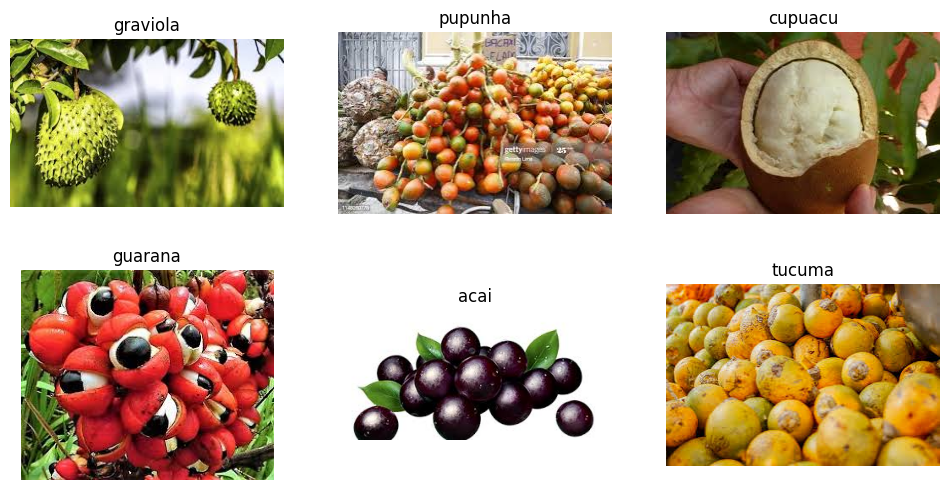

In [6]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [7]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [8]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [11]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [12]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.1655 - loss: 2.2016

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 689ms/step - accuracy: 0.1623 - loss: 2.2458 - val_accuracy: 0.0000e+00 - val_loss: 1.7487
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.1997 - loss: 1.7489

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.2018 - loss: 1.7441 - val_accuracy: 0.0556 - val_loss: 1.7554
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3304 - loss: 1.6252

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 836ms/step - accuracy: 0.3277 - loss: 1.6241 - val_accuracy: 0.3889 - val_loss: 1.6216
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.5608 - loss: 1.4581

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.5560 - loss: 1.4553 - val_accuracy: 0.4444 - val_loss: 1.4635
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5399 - loss: 1.2564

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step - accuracy: 0.5404 - loss: 1.2516 - val_accuracy: 0.8333 - val_loss: 0.9310
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.6584 - loss: 1.0847 - val_accuracy: 0.7222 - val_loss: 1.0731
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.8277 - loss: 0.8183 - val_accuracy: 0.5556 - val_loss: 1.1559
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - accuracy: 0.8407 - loss: 0.6594 - val_accuracy: 0.8333 - val_loss: 0.6794
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9502 - loss: 0.4376

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.9488 - loss: 0.4444 - val_accuracy: 0.8889 - val_loss: 0.4722
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9891 - loss: 0.2630 - val_accuracy: 0.6111 - val_loss: 0.9994
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 650ms/step - accuracy: 0.9449 - loss: 0.2632 - val_accuracy: 0.8333 - val_loss: 0.5021
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step - accuracy: 1.0000 - loss: 0.1072 - val_accuracy: 0.8889 - val_loss: 0.4560
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 0.9674 - loss: 0.1245 - val_accuracy: 0.8889 - val_loss: 0.4033
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - accuracy: 1.0000 - loss: 0.0457 - val_accuracy: 0.7778 - val_loss: 0.5747
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.9705 - loss: 0.0992 - val_accuracy: 0.8889 - val_loss: 0.5044
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.8889 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 577ms/step - accuracy: 1.0000 - loss: 0.0348 - val_accuracy: 0.9444 - val_loss: 0.2691
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 804ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 0.9444 - val_loss: 0.1616
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 532ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.9444 - val_loss: 0.1855
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step - accuracy: 1.0000 - loss: 0.0119 - val_accuracy: 0.8889 - val_loss: 0.2157
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.8889 - val_loss: 0.3349
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.8889 - val_loss: 0.4173
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 718ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.8333 - val_loss: 0.4439
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 759ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8333 - val_lo

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 1.2748
Test Accuracy: 66.67%


In [16]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
              precision    recall  f1-score   support

    graviola       0.71      1.00      0.83         5
     pupunha       0.67      0.40      0.50         5
     cupuacu       0.56      1.00      0.71         5
     guarana       1.00      0.40      0.57         5
        acai       0.71      1.00      0.83         5
      tucuma       0.50      0.20      0.29         5

    accuracy                           0.67        30
   macro avg       0.69      0.67      0.62        30
weighted avg       0.69      0.67      0.62        30



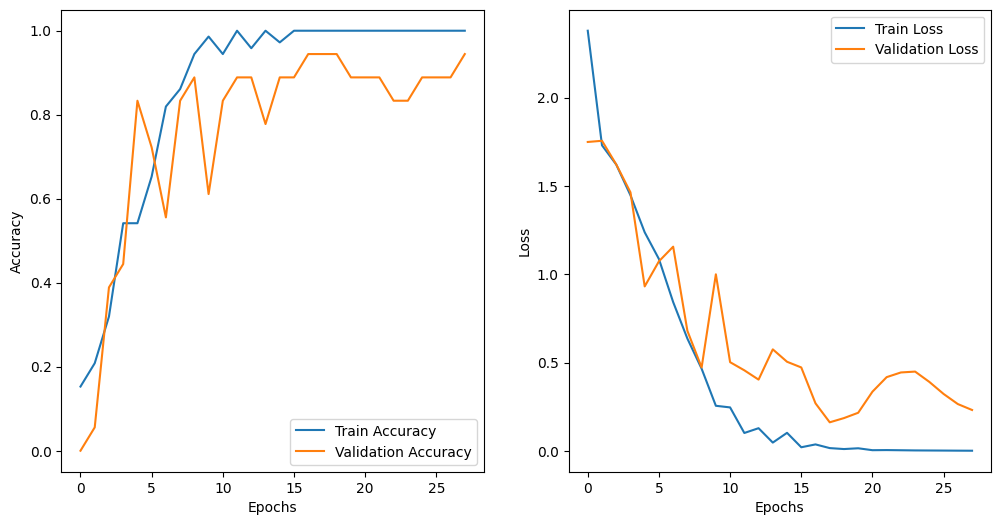

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()